In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
%matplotlib inline
import time
import pylab as pl
from IPython import display
from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
# Check if a GPU is available
if torch.cuda.is_available():
    # Set the default device to GPU
    torch.cuda.set_device(0)  # You can specify the GPU index (0, 1, etc.) if you have multiple GPUs
else:
    print("No GPU available. Switching to CPU.")

Using device: cuda


In [6]:
# Data hyper-parameters
N = 2500              # nr of datapoints

# Model hyper-parameters
init_gamma_0 = -13.3    # initial gamma_0
init_gamma_1 = 5.       # initial gamma_1
hidden_units = 512
T_train = 0                   # nr of timesteps in model; T=0 means continuous-time
vocab_size = 256

# Optimization hyper-parameters
learning_rate = 2.5e-3  
num_train_steps =  15000    

rng = jax.random.PRNGKey(seed=0)
np.random.seed(0)

(2500, 3)


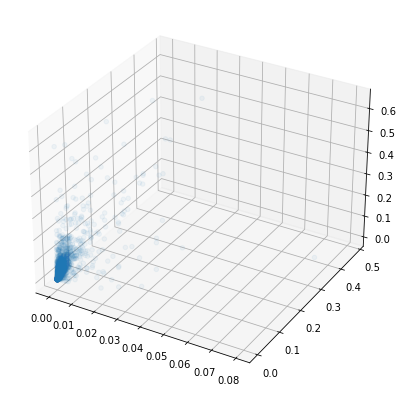

In [11]:
layer = np.load('layer_array.npy').T
layer.shape
x = layer.astype('float32')[:,1:4]
print(x.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')

img = ax.scatter(x[:,0],x[:,1],x[:,2], alpha=0.05)
plt.show()
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)

In [12]:
# Define learnable model
class Model(nn.Module):

    def setup(self):
        self.score_net = ScoreNetwork()
        self.noise_schedule = NoiseSchedule()

    def __call__(self, x, t):
        gamma_t = self.noise_schedule(t)
        return self.score_net(x, gamma_t)

    def score(self, x, t):
        return self.score_net(x, t)

    def gamma(self, t):
        return self.noise_schedule(t)

# A fully-connected MLP as the score network
class ScoreNetwork(nn.Module):

    def setup(self):
        self.dense1 = nn.Dense(hidden_units)
        self.dense2 = nn.Dense(hidden_units)
        self.dense3 = nn.Dense(3)
        self.ff = Base2FourierFeatures()

    def __call__(self, z, gamma_t):

        # Normalize gamma_t
        lb = init_gamma_0
        ub = init_gamma_1
        gamma_t_norm = ((gamma_t - lb) / (ub - lb))*2-1  # ---> [-1,+1]

        # Concatenate normalized gamma_t as extra feature
        h = jnp.concatenate([z, gamma_t_norm[:, None]], axis=1)

        # append Fourier features
        h_ff = self.ff(h)
        h = jnp.concatenate([h, h_ff], axis=1)

        # Three dense layers
        h = nn.swish(self.dense1(h))
        h = nn.swish(self.dense2(h))
        h = self.dense3(h)

        return h

class Base2FourierFeatures(nn.Module):
    # Create Base 2 Fourier features
    @nn.compact
    def __call__(self, inputs):
        freqs = jnp.asarray(range(32), dtype=inputs.dtype) #[0, 1, ..., 32]  embed_dim
        w = 2.**freqs * 2 * jnp.pi
        w = jnp.tile(w[None, :], (1, inputs.shape[-1]))
        h = jnp.repeat(inputs, len(freqs), axis=-1)
        h *= w
        h = jnp.concatenate([jnp.sin(h), jnp.cos(h)], axis=-1)

        return h

def constant_init(value, dtype='float32'):
    def _init(key, shape, dtype=dtype):
        return value * jnp.ones(shape, dtype)
    return _init

# Simple scalar noise schedule, i.e. gamma(t) in the paper:
# gamma(t) = abs(w) * t + b
class NoiseSchedule(nn.Module):

    def setup(self):
        init_bias = init_gamma_0
        init_scale = init_gamma_1 - init_gamma_0
        self.w = self.param('w', constant_init(init_scale), (1,))
        self.b = self.param('b', constant_init(init_bias), (1,))

    def __call__(self, t):
        return abs(self.w) * t + self.b

def data_encode(x):
  # This transforms x from discrete values (0, 1, ...)
  # to the domain (-1,1).
  # Rounding here just a safeguard to ensure the input is discrete
  # (although typically, x is a discrete variable such as uint8)
    x = x
    return (x-x_mean)/x_std

def data_decode(z_0_rescaled, gamma_0):
  # Logits are exact if there are no dependencies between dimensions of x
    x_vals = jnp.arange(0, vocab_size)[:, None]
    x_vals = jnp.repeat(x_vals, z_0_rescaled.shape[-1], 1)
    x_vals = data_encode(x_vals).transpose([1, 0])[None, :, :]
    inv_stdev = jnp.exp(-0.5 * gamma_0[..., None])
    logits = -0.5 * jnp.square((z_0_rescaled[..., None] - x_vals) * inv_stdev)

    logprobs = jax.nn.log_softmax(logits)
    return logprobs

def data_logprob(x, z_0_rescaled, gamma_0):
    x = x.astype('float32')
    x_onehot = jax.nn.one_hot(x, vocab_size)
    logprobs = data_decode(z_0_rescaled, gamma_0)
    logprob = jnp.sum(x_onehot * logprobs, axis=(1, 2))
    return logprob

def data_generate_x(z_0, gamma_0, rng):
    var_0 = nn.sigmoid(gamma_0)
    z_0_rescaled = z_0 / jnp.sqrt(1. - var_0)
    logits = data_decode(z_0_rescaled, gamma_0)
    samples = jax.random.categorical(rng, logits)
    return samples

# define loss function
def loss_fn(params, x, rng):

    gamma = lambda t: model.apply(params, t, method=Model.gamma)
    gamma_0, gamma_1 = gamma(0.), gamma(1.)
    var_0, var_1 = nn.sigmoid(gamma_0), nn.sigmoid(gamma_1)
    n_batch = x.shape[0]

    # encode
    f = data_encode(x)

    # 1. RECONSTRUCTION LOSS
    # add noise and reconstruct
    rng, rng1 = jax.random.split(rng)
    eps_0 = jax.random.normal(rng1, shape=f.shape)
    z_0 = jnp.sqrt(1. - var_0) * f + jnp.sqrt(var_0) * eps_0
    z_0_rescaled = f + jnp.exp(0.5 * gamma_0) * eps_0  # = z_0/sqrt(1-var)
    loss_recon = - data_logprob(x, z_0_rescaled, gamma_0)

    # 2. LATENT LOSS
    # KL z1 with N(0,1) prior
    mean1_sqr = (1. - var_1) * jnp.square(f)
    loss_klz = 0.5 * jnp.sum(mean1_sqr + var_1 - jnp.log(var_1) - 1., axis=1)

    # 3. DIFFUSION LOSS
    # sample time steps
    rng, rng1 = jax.random.split(rng)
    t = jax.random.uniform(rng1, shape=(n_batch,))

    # discretize time steps if we're working with discrete time
    if T_train > 0:
        t = jnp.ceil(t * T_train) / T_train

    # sample z_t
    gamma_t = gamma(t)
    var_t = nn.sigmoid(gamma_t)[:, None]
    rng, rng1 = jax.random.split(rng)
    eps = jax.random.normal(rng1, shape=f.shape)
    z_t = jnp.sqrt(1. - var_t) * f + jnp.sqrt(var_t) * eps
    # compute predicted noise
    eps_hat = model.apply(params, z_t, gamma_t, method=Model.score)
    # compute MSE of predicted noise
    loss_diff_mse = jnp.sum(jnp.square(eps - eps_hat), axis=1)

    if T_train == 0:
        # loss for infinite depth T, i.e. continuous time
        _, g_t_grad = jax.jvp(gamma, (t,), (jnp.ones_like(t),))
        loss_diff = .5 * g_t_grad * loss_diff_mse
    else:
        # loss for finite depth T, i.e. discrete time
        s = t - (1./T_train)
        gamma_s = gamma(s)
        loss_diff = .5 * T_train * jnp.expm1(gamma_t - gamma_s) * loss_diff_mse

    # End of diffusion loss computation

    # Compute loss in terms of bits per dimension
    rescale_to_bpd = 1./(np.prod(x.shape[1:]) * np.log(2.))
    bpd_latent = jnp.mean(loss_klz) * rescale_to_bpd
    bpd_recon = jnp.mean(loss_recon) * rescale_to_bpd
    bpd_diff = jnp.mean(loss_diff) * rescale_to_bpd
    bpd = bpd_recon + bpd_latent + bpd_diff
    loss = bpd
    metrics = [bpd_latent, bpd_recon, bpd_diff]
    return loss, metrics

# define training step
@jax.jit
def train_step(rng, optim_state, params, x):
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    rng, rng1 = jax.random.split(rng)
    (loss, metrics), grads = grad_fn(params, x, rng1)
    updates, optim_state = optimizer.update(grads, optim_state, params)
    params = optax.apply_updates(params, updates)
    return rng, optim_state, params, loss, metrics


In [13]:
# Initialize model
model = Model()
rng, rng1, rng2 = jax.random.split(rng, 3)
init_inputs = [128*jnp.ones((1, 3)), jnp.zeros((1,))]
params = model.init({"params": rng1, "sample": rng2}, *init_inputs)

# initialize optimizer
optimizer = optax.adamw(learning_rate)
optim_state = optimizer.init(params)

In [14]:
# training loop (should take ~20 mins)
losses = []
for i in trange(num_train_steps):
    rng, optim_state, params, loss, _metrics = train_step(rng, optim_state, params, x)
    losses.append(loss)

  0%|          | 0/15000 [00:00<?, ?it/s]

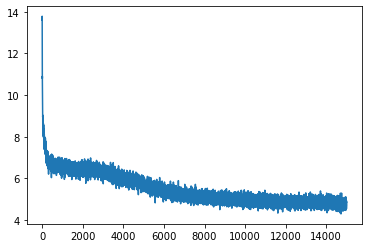

In [15]:
plt.plot(losses)

In [16]:
# Plot the learned endpoints of the noise schedule
print('gamma_0', model.apply(params, 0., method=Model.gamma))
print('gamma_1', model.apply(params, 1., method=Model.gamma))

gamma_0 [-13.425105]
gamma_1 [4.6623297]


In [17]:
# define sampling function
# t_end is integer between 0 and T_sample
def sample_fn(rng, params, N_sample, T_sample):
    # sample z_0 from the diffusion model
    rng, rng1 = jax.random.split(rng)
    z = [jax.random.normal(rng1, (N_sample,3))]
    x_pred = []

    for i in trange(T_sample):
        rng, rng1 = jax.random.split(rng)
        _z, _x_pred = sample_step(i, T_sample, z[-1], rng1)
        z.append(_z)
        x_pred.append(_x_pred)

    gamma_0 = model.apply(params, 0., method=Model.gamma)
    x_sample = data_generate_x(z[-1], gamma_0, rng)

    return z, x_pred, x_sample

def sample_step(i, T_sample, z_t, rng):

    eps = jax.random.normal(rng, z_t.shape)

    t = (T_sample - i) / T_sample
    s = (T_sample - i - 1) / T_sample

    gamma_s = model.apply(params, s, method=Model.gamma)
    gamma_t = model.apply(params, t, method=Model.gamma)
    gamma_s *= jnp.ones((z_t.shape[0],), gamma_t.dtype)
    gamma_t *= jnp.ones((z_t.shape[0],), gamma_t.dtype)

    eps_hat = model.apply(params, z_t, gamma_t, method=Model.score)
    a = nn.sigmoid(-gamma_s)[:,None]
    b = nn.sigmoid(-gamma_t)[:,None]
    c = - jnp.expm1(gamma_s - gamma_t)[:,None]
    sigma_t = jnp.sqrt(nn.sigmoid(gamma_t))[:,None]

    z_s = jnp.sqrt(a / b) * (z_t - sigma_t * c * eps_hat) + \
        jnp.sqrt((1. - a) * c) * eps

    alpha_t = jnp.sqrt(1 - b)
    x_pred = (z_t - sigma_t * eps_hat)/alpha_t

    return z_s, x_pred

In [25]:
# Generate samples
rng, rng1 = jax.random.split(rng)
z, x_pred, _ = sample_fn(rng1, params, N_sample=2500, T_sample=500)

  0%|          | 0/500 [00:00<?, ?it/s]

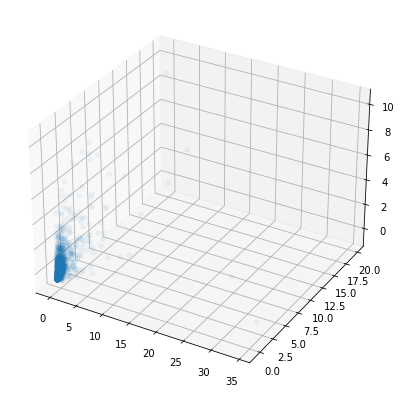

In [26]:
x1 = z[499]
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')

img = ax.scatter(x1[:,0],x1[:,1],x1[:,2], alpha=0.05)
plt.show()

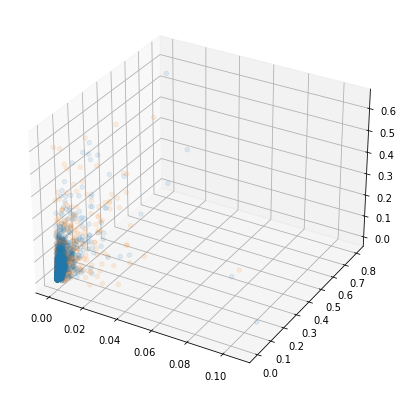

In [27]:
x11 = x1*x_std+x_mean
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')



img = ax.scatter(x11[:,0],x11[:,1],x11[:,2], alpha=0.1)
img = ax.scatter(x[:,0],x[:,1],x[:,2], alpha=0.1)

plt.show()

/tmp/ipykernel_411/2252029570.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(grid[0])
/tmp/ipykernel_411/2252029570.py:21: RuntimeWarning: divide by zero encountered in divide
  density_ratio = density1 / density2
/tmp/ipykernel_411/2252029570.py:21: RuntimeWarning: invalid value encountered in divide
  density_ratio = density1 / density2
/tmp/ipykernel_411/2252029570.py:28: RuntimeWarning: invalid value encountered in divide
  uncertainty_ratio = density_ratio * np.sqrt((y_error1 / density1)**2 + (y_error2 / density2)**2)
/tmp/ipykernel_411/2252029570.py:30: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax2.errorbar((bins1[:-1] + bin_width1 / 2)[0:30], density_ratio[0:30], yerr=(uncertainty_ratio/2)[0:30], marker='o' ,fmt='

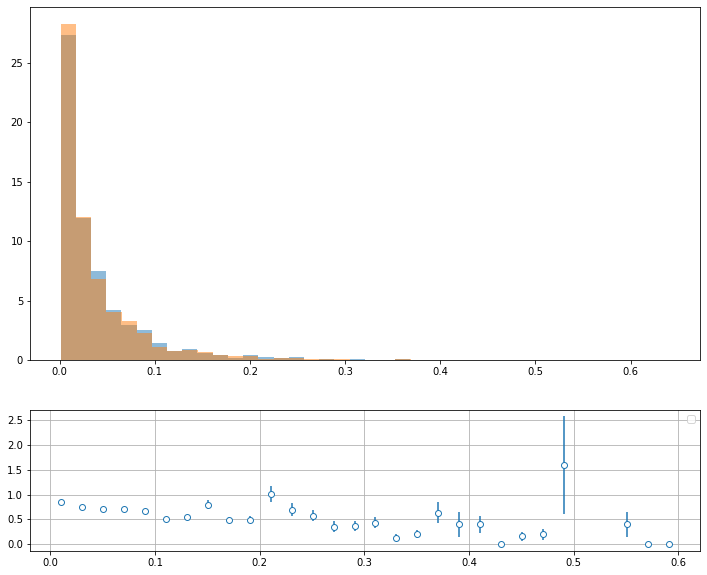

In [54]:
import matplotlib.gridspec as gridspec
fig, axs = plt.subplots( figsize=(12,10) )
grid = gridspec.GridSpec(2, 1,  height_ratios=[5, 2])
ax1 = plt.subplot(grid[0])
ax1.hist( x11[:,2], alpha=0.5, density=True, bins=40, label = 'gen' )
ax1.hist( x[:,2], alpha=0.5, density=True, bins=40, label = 'truth' )
data1 = x11
data2 = x
hist1, bins1 = np.histogram(data1, bins=40)
hist2, bins2 = np.histogram(data2, bins=40)
# Calculate bin widths
bin_width1 = bins1[1] - bins1[0]
bin_width2 = bins2[1] - bins2[0]

# Calculate densities for each bin
density1 = hist1 / (len(data1) * bin_width1)
density2 = hist2 / (len(data2) * bin_width2)

tolerance = 1e-6
# Calculate density ratio between corresponding bins
density_ratio = density1 / density2

# Simulated y-errors (standard deviations)
y_error1 = np.sqrt(hist1) / (len(data1) * bin_width1)
y_error2 = np.sqrt(hist2) / (len(data2) * bin_width2)

# Calculate uncertainty in the ratio considering y-errors
uncertainty_ratio = density_ratio * np.sqrt((y_error1 / density1)**2 + (y_error2 / density2)**2)
ax2 = plt.subplot(grid[1])
ax2.errorbar((bins1[:-1] + bin_width1 / 2)[0:30], density_ratio[0:30], yerr=(uncertainty_ratio/2)[0:30], marker='o' ,fmt='*',mfc = 'w')
ax2.grid(True)

plt.legend()
plt.show()